<hr/>

# Preprocessing and data summary 

**_Data preparation for LDA, Word2Vec, Doc2Vec and Clustering for NLP_**

<hr/>

**Important:** Some arguments for tuning are defined on a separate json file to avoid clutter. To view a description of each methods and arguments, see modules `helper.helper_funs` and `helper.word_preprocess`. Additional functionality can be found there as well. 

<hr/>

To manually **adjust which code cells are viewed**:

   * To hide a single cell, type `one_cell_toggle()`

   * To hide every cell, type `toggled()`
   
Then click the link below the hidden cell(s) to hide or show the code   


May need to download some nltk features nltk.download(['punkt', 'stopwords', 'wordnet'])
    


In [1]:
%matplotlib inline

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # may trigger a deprecation warning 

import pandas as pd
import random
import json
from os.path import exists

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
from sklearn.model_selection import train_test_split
import gensim

from textblob import TextBlob  # if using automatic grammar correction (very slow)

# local modules
from helper.helper_funs import time_filename, save_folder_file, logged, RenderJSON
from helper.word_preprocess import DataLoader, CleanText, WordCount, PlotWords
from methods.word_doc2vec import make_bigrams, count_bigrams
from helper.dk_ipython import toggled, one_cell_toggle

one_cell_toggle()

### Loading Parameter Tuning Files and setting path for saved results

In [2]:
with open('changeable_parameters/tuning_params.json') as json_file:  
    tune_params = json.load(json_file)
    
cleaned_data_path = 'data/processed_data/cleaned_data.json' 

if exists(cleaned_data_path):
    print("\t***\nWARNING! This notebook will overwrite the file {}".format(cleaned_data_path))
    print("\nChange filename if necessary")
else:
    print('Cleaned dataset will be stored in {}'.format(cleaned_data_path))
    
lda_table_path = 'results/lda_table_path.csv'    # path for LDA results is here to tag dataset for other notebooks

regex_path = 'changeable_parameters/cleaning_regex.json'

one_cell_toggle()

Cleaned dataset will be stored in data/processed_data/cleaned_data.json


### Here we can display the tunable parameters 

We will be using these parameters in this notebook, the LDA, Word2Vec and Doc2Vec demos as well.

<hr/>

**_To view each parameter in detail, click on the XOR symbol link_** (Only works with a web connection)

In [3]:
RenderJSON(tune_params)

<hr/>

### Setting all local variables 

<hr/>

Details in comments

In [4]:
seed = 290 
random.seed(seed)

to_log = False              # set to True to get log files
padded_data = True          # set to True to use extended scraped dataset
with_bigrams = True         # set to decide if using bigrams or not
with_trigrams = False       # set to decide if using trigrams or not
correct_grammar = False     # set to True to use textblob grammar/typo corrector (VERY slow)

stemmer = 'Porter'          # 'Snowball', 'Porter' or 'Lancaster' available
stem_results = PorterStemmer()
removed_language = ['french']  # delete if there are no `Languages` column in the data file

test_set_prop = 0.1         # proportion of data to hold out for test (if using a test set)

# ----------------------------------------------------------------------------------------- #

min_len = 3
if with_bigrams:
    min_len = 1      # if using n-grams, keep small words to allow for words like 'for profit' or 'at risk'

if to_log:           # starting log file, optional
    full_path_log = logged(filename='preprocess')    

### Fetching data and Tunable Parameters:

In [5]:
asc_stopwords = tune_params['added_stopwords']

col = tune_params['main_col']
col_bc = tune_params['bc_col']
col_world = tune_params['world_col']

stop = set(stopwords.words(['english', 'french'])) # words to remove from corpus  

# list of stopwords specific to this project imported from `helper.extra_stopwords` module
stop.update(asc_stopwords)

data = DataLoader(filename='artbridges_profiles.csv', 
                       data_folder='../data',
                       colname=col,  # column(s) to remove weird chars
                       rm_NAs=True,  # completely remove records with NaNs 
                                     #(implemented for 1st column only, other cols replace NaN with empty strings and concat)
                       removed_language=removed_language, # list of languages to remove (lowercase)
                       greedy_url_regex=True) # remove urls aggressively or conservatively

# NOTE: ASC dataset removes some english words when removing french

# Scraped world ASC data
xtra_data = DataLoader(filename='world_arts.csv', 
                       data_folder='../data',
                       colname=col_world, 
                       rm_NAs=True, 
                       removed_language=[], 
                       label_colname='Name',
                       greedy_url_regex=True)                                

# BC dataset
data2 = DataLoader(filename='artbridges_test.csv', 
                       data_folder='../data',
                       colname=col_bc,  
                       rm_NAs=True, 
                       removed_language=removed_language,
                       greedy_url_regex=True) # list of languages to remove (lowercase)

one_cell_toggle()

In [6]:
# examples of problem mission statements: â, Lâ 

donnee, org_names = data.data_loader(regex_path=regex_path)  
xtra_donnee, xtra_org_names = xtra_data.data_loader(regex_path=regex_path)  
donnee2, label_list2 = data2.data_loader(regex_path=regex_path)    

one_cell_toggle()

Reading and cleaning data file...

Removing duplicates based on column: Mandate/Mission...

Can only remove NaNs in Mandate/Mission, subsequent columns will change NaNs into empty strings and later concatenate to first column

Removing french texts...


72 url(s) removed.

2 handle name(s) removed.

Done!

********************
Reading and cleaning data file...

Removing duplicates based on column: Mission...


1 url(s) removed.

0 handle name(s) removed.

Done!

********************
Reading and cleaning data file...

Removing duplicates based on column: Mandate/Mission...

Can only remove NaNs in Mandate/Mission, subsequent columns will change NaNs into empty strings and later concatenate to first column

Removing french texts...


10 url(s) removed.

0 handle name(s) removed.

Done!

********************


In [7]:
# concatenate all datasets together if using additional datasets for padding
if padded_data:
    print('Using augmented dataset')
    all_donnees = donnee + xtra_donnee + donnee2
    all_labels = org_names + xtra_org_names + label_list2

else:    
    print('Using original (Canada + BC) dataset')
    all_donnees = donnee + donnee2
    all_labels = org_names + label_list2      
    
one_cell_toggle()

Using augmented dataset


<hr/>

## Clean all data, preprocess, stem, lemmatize and tokenize:

#### Stemming and Lemmatization:

**Goal:** simplify word representations into base forms (i.e.: "creat", "disabl", etc.). There are multiple stemming methods, here we can implement `Porter` (standard), `Lancaster` (more aggressive, drastic stemming) and `Snowball` (language specific). 

The method used to stem or lemmatize words can noticeably affect the topic clustering process.

<hr/>

**Some definitions:**

**Stemming:** Word mappings to word bases (stems) used to bypass differences in semantically identical words due to word inflections such as verb tense or plural forms. There is loss of information incurred in the stemming process, since context is not taken into account. The algorithm assumes that words are separate entities unrelated to their surroundings - homonyms are treated as the same word regardless of meaning.

**Lemmatization:** Very similar to stemming, lemmatization is a many-to-one mapping of different forms of inflected words into a generalized word representation (lemma). Contrary to stemming, lemmatization takes context, meaning and neighbouring words into account, thus incurs less information loss. 

**Stemming vs. lemmatization:** Speed vs. precision trade-off.

<hr/>

#### Our approach to stemming and lemmatization:

**Hybrid approach:** _"lemmatized stemming"_, first lemmatize, retaining contextual information and stem the result following a predetermined degree of pruning. 

We use the most common lexical database for lemmatization (as of Spring 2019), **Wordnet**, with the `nltk` library. 

To fully take advantage of the contextual information conveyed by the lemmatization process, we tagged the data with **Wordnet's** "part-of-speech" (POS) tagging. We can leverage information gained from the Wordnet data to assign grammatical roles to each word, according to context <span id="pos">[[see 1-]](#d1)</span> . 


<hr/>

#### Part-Of-Speech Tags

Grammatical tags provided by the Wordnet pos-tag method: 

   * Verb, noun, pronoun, adjectiv, adverb, preposition, conjunction and interjection. 
   
   
#### Tokenization:

Simply the process of separating single words as discrete objects. Tokenization is a natural partner to LDA, since each individual word is modeled as a separate agent, where only multiplicity is accounted for, not position nor direction.

In [8]:
clean = CleanText(all_donnees,
                  stop=stop,
                  stemmer=stemmer)

processed_data = clean.preprocess(min_len = min_len)


Getting customized POS tags from WordNet may take some time...



In [9]:
# to correct grammar or typos (VERY long to run)

if correct_grammar:
    # first run preprocess again but for a Series type
    textdata = clean.preprocess(min_len = min_len,
                                as_series = True,
                                custom_pos = False)
    textdata.apply(lambda x: str(TextBlob(x).correct()))
    processed_data = list(textdata)
    
one_cell_toggle()    

In [10]:
# Make n-gram words if desired (ie: 'social justice' instead of 'social', 'justice')

if with_bigrams:
    processed_data = make_bigrams(processed_data)
    textdata = pd.Series([' '.join(item) for item in processed_data])
    
    if with_trigrams:
        processed_data = make_bigrams(processed_data)
        textdata = pd.Series([' '.join(item) for item in processed_data])
        
one_cell_toggle()            

In [11]:
# Make train/test sets if needed

train, test, train_lab, test_lab = train_test_split(processed_data, 
                                                    all_labels, 
                                                    test_size=test_set_prop, 
                                                    random_state=seed)

assert len(test) == len(test_lab) and len(train) == len(train_lab)

one_cell_toggle()    

### Recording all data and associated parameters 

to a `clean_data.json` file

In [12]:
cleaned_data = {"all_donnees": all_donnees, 
                "all_labels":  all_labels,
                "processed_data": processed_data,
                "train": train,
                "test": test,
                "train_lab": train_lab,
                "test_lab": test_lab,
                "generating_params": {"added_stopwords": asc_stopwords,
                                      "main_text_col": col,
                                      "seed": seed, 
                                      "padded_data": padded_data,     
                                      "with_bigrams": with_bigrams,
                                      "with_trigrams": with_trigrams,
                                      "correct_grammar": correct_grammar,
                                      "stemmer": stemmer,
                                      "removed_language": removed_language,
                                      "test_set_prop": test_set_prop,
                                      "min_len": min_len,
                                      "lda_table_path": lda_table_path}
                }
                                      
one_cell_toggle()                                                                         

In [13]:
with open(cleaned_data_path, "wb") as json_data:
    json_data.write(json.dumps(cleaned_data).encode("utf-8"))

<hr/>

### The resulting cleaned dataset can then be used for LDA and Word/Doc2Vec

<hr/>

Some descriptive statistics:

In [14]:
n_words = 10 # number of 'most common' words to print

wp = WordCount(processed_data)
word_count = wp.dict_count(verbose=0) # verbose: number of documents to show in output
raw_count = WordCount(donnee).count_words()

num_words = sum(list(word_count.values())) # list() optional, depending on python version - ML
print("\nThere are {} words in the combination of all mission statements.".format(raw_count))
print("There are {} words in all statements given (after preprocess).".format(num_words))

one_cell_toggle()    


There are 31069 words in the combination of all mission statements.
There are 40760 words in all statements given (after preprocess).


In [15]:
print('These are the {} most common terms:'.format(n_words))
word_count.most_common()[:n_words]    

These are the 10 most common terms:


[('program', 543),
 ('work', 472),
 ('cultur', 391),
 ('youth', 378),
 ('creativ', 353),
 ('project', 325),
 ('develop', 319),
 ('creat', 313),
 ('theatr', 303),
 ('educ', 270)]

In [16]:
if with_bigrams:
    print('Most common bigrams:\n')
    bi_count = count_bigrams(processed_data)
    
one_cell_toggle()        

Most common bigrams:

young_peopl 102
social_chang 65
first_nation 51
non-profit_organ 43
child_youth 33
profession_develop 29
provid_opportun 28
bring_togeth 25
danc_music 24
mental_health 22
social_justic 22
creativ_express 21
visual_medium 20
tell_stori 20
theatr_compani 20
human_right 19
outreach_program 16
new_medium 16
spoken_word 15
wide_rang 14


## Interactive frequency plot: click to open local server and edit or save plot

Note: a still version of the plot can be automatically saved only if Orca commandline util and psutil library is installed. Otherwise, set `save_plot` argument to `False` to generate the plot inline only (click `download as png` to save).

If the plot is blank, you may need to relaunch the notebook with this flag:

`jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10`

In [17]:
view_data = PlotWords(word_count)

view_data.freq_plot(top_n=50, save_plot=True) # top_n number of top words to show

Directory does not exist, creating a new directory named /visualization/2019-2-25/...

Pyplot word frequency bar chart saved to `visualization/2019-2-25/word_frequency_barplot_top50_words_17h32m57s.png`.



## Cloud Plot

**Displays the most common (stemmed and lemmatized) words**

Larger words indicate more common words.

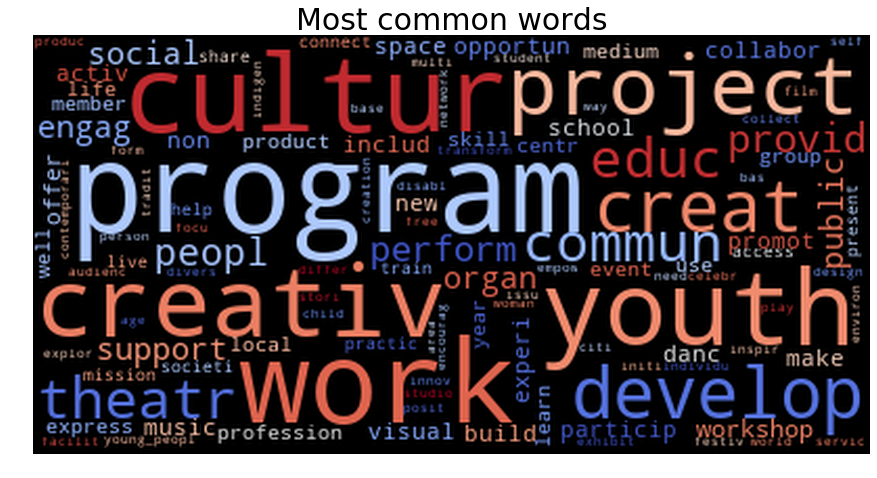

Wordcloud plot saved to `visualization/2019-2-25/wordcloud_plot_17h33m8s.png`.



<Figure size 432x288 with 0 Axes>

In [18]:
view_data.cloud_plot(size=(15,12), 
                     max_font_size=60,
                     min_font_size=5)